#### Versions:
* v9: ColorJitter transformation added **[0.896]**
* v10: Changed the dataset to [this one](https://www.kaggle.com/shonenkov/melanoma-merged-external-data-512x512-jpeg) with external data. **[0.894]**
* v11: Switched to [another dataset](https://www.kaggle.com/nroman/melanoma-external-malignant-256/) which I've created by myself. Also switched from StratifiedKFold to GroupKFold **[0.916]**
* v12: Switched to efficientnet-b1 **[0.919]**
* v13: Using meta featues: sex and age **[0.918]**
* v14: anatom_site_general_challenge meta feature added as one-hot encoded matrix **[0.923]**
* v16: Fixed OOF - now it contains only data from original training dataset, without extarnal data. Also switched back to StratifiedKFold. Added DrawHair augmentation. **[0.909]**
* v18: Too many things were changed at the same time. All experiments should have only one small change each, so it would be easy to understand how changes affect the result. Said that I rolled back everything, keeping only OOF fix, to make sure it work.
* v19: Added 'Hair' augmentation. OOF rework posponed untill the best time, since there is some bug in my code for it. **[0.925]**
* v20: Advanced Hair Augmentation technique used. Read more about it here: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/159176 **[0.923]**
* v21: Microscope augmentation added instead of Cutout. Read more here: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/159476

In [1]:
!pip install efficientnet_pytorch torchtoolbox

In [2]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
# import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Mon Jul  6 01:27:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
Kaggle = False
Colab = !Kaggle

In [5]:
import os, sys
from pathlib import Path

# if Colab:
#     from google.colab import drive
#     drive.mount('/content/drive')

#     path = "/content/drive/My Drive"

#     os.chdir(path)
#     os.listdir(path)

if Colab:
    from google.colab import drive
    drive.mount('/content/drive', , force_remount=True)

    path = "/content/drive/My Drive"
    os.chdir(path)
    os.listdir(path)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [6]:
if Kaggle:
    PATH = '/kaggle/input/'
    outdir = '.'
else:
    PATH = 'siim/'
    outdir = Path(PATH+'res')
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    outdir = Path(PATH+'res/efficientnet-res')
    if not os.path.exists(outdir):
        os.mkdir(outdir)

In [7]:
MODELNAME = "EF1"
VERSION = '{}'.format(MODELNAME)
outdir = os.path.join(outdir, VERSION)
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [8]:
from datetime import datetime, timedelta
dateTimeObj = datetime.now()
# timestampStr = dateTimeObj.strftime("%d-%b-%Y-%H")
timestampStr = 'all'
outdir = os.path.join(outdir, timestampStr)
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [9]:
# print(str(timedelta(seconds=7)))

In [10]:
# At least fixing some random seeds. 
# It is still impossible to make results 100% reproducible when using GPU
warnings.simplefilter('ignore')
torch.manual_seed(47)
np.random.seed(47)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms = None, meta_features = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        # print(im_path)
        x = cv2.imread(im_path)
        # print(x.shape)
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)
        # print(meta.shape)
        if self.transforms:
            x = self.transforms(x)
            
        if self.train:
            y = self.df.iloc[index]['target']
            return (x, meta), y
        else:
            return (x, meta)
    
    def __len__(self):
        return len(self.df)
    
    
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 250 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

In [13]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        n_hairs = random.randint(0, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
        # print("aug done")
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [14]:
class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

In [15]:
train_transform = transforms.Compose([
    AdvancedHairAugmentation(hairs_folder=os.path.join(PATH, 'melanoma-hairs/')),
    transforms.RandomResizedCrop(size=256, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    Microscope(p=0.6),
#     transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [16]:
arch = EfficientNet.from_pretrained('efficientnet-b1')  # Going to use efficientnet-b1 NN architecture
# skf = StratifiedKFold(n_splits=5, random_state=999, shuffle=True)
skf = GroupKFold(n_splits=5)

Loaded pretrained weights for efficientnet-b1


In [17]:
if Kaggle:
    train_df = pd.read_csv(PATH+'melanoma-external-malignant-256/train_concat.csv')
    test_df = pd.read_csv(PATH+'siim-isic-melanoma-classification/test.csv')
else:
    train_df = pd.read_csv(PATH+'melanoma-external-malignant-256/train_concat.csv')
    test_df = pd.read_csv(PATH+'melanoma-external-malignant-256/test.csv')



In [18]:
display(train_df.head())

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,0


In [19]:
display(test_df.head())

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [20]:
if os.path.exists('siim'):
    # Open a file
    path = "siim"
    dirs = os.listdir( path )

    # This would print all the files and directories
    for file in dirs:
        print(file)

701123_1225697_bundle_archive.zip
melanoma-hairs
res
melanoma-external-malignant-256


In [21]:
# One-hot encoding of anatom_site_general_challenge feature
concat = pd.concat([train_df['anatom_site_general_challenge'], test_df['anatom_site_general_challenge']], ignore_index=True)
dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
train_df = pd.concat([train_df, dummies.iloc[:train_df.shape[0]]], axis=1)
test_df = pd.concat([test_df, dummies.iloc[train_df.shape[0]:].reset_index(drop=True)], axis=1)

# Sex features
train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})
train_df['sex'] = train_df['sex'].fillna(-1)
test_df['sex'] = test_df['sex'].fillna(-1)

# Age features
train_age_max = train_df['age_approx'].max()
train_df['age_approx'] /= train_age_max
test_df['age_approx'] /= train_age_max
train_df['age_approx'] = train_df['age_approx'].fillna(0)
test_df['age_approx'] = test_df['age_approx'].fillna(0)

train_df['patient_id'] = train_df['patient_id'].fillna(0)

In [22]:
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

In [23]:
test = MelanomaDataset(df=test_df,
                       imfolder= PATH+'melanoma-external-malignant-256/test/test/', 
                       train=False,
                       transforms=train_transform,
                       meta_features=meta_features)

In [26]:
# os.listdir("siim/melanoma-external-malignant-256/test/test/")

['ISIC_8602499.jpg',
 'ISIC_8651294.jpg',
 'ISIC_9067229.jpg',
 'ISIC_8833433.jpg',
 'ISIC_8368715.jpg',
 'ISIC_9253878.jpg',
 'ISIC_8424661.jpg',
 'ISIC_9349521.jpg',
 'ISIC_9028698.jpg',
 'ISIC_8850011.jpg',
 'ISIC_8636351.jpg',
 'ISIC_8409838.jpg',
 'ISIC_8497203.jpg',
 'ISIC_9045135.jpg',
 'ISIC_9002755.jpg',
 'ISIC_8415134.jpg',
 'ISIC_9317637.jpg',
 'ISIC_8935177.jpg',
 'ISIC_8768167.jpg',
 'ISIC_8302863.jpg',
 'ISIC_8924557.jpg',
 'ISIC_8372206.jpg',
 'ISIC_9064712.jpg',
 'ISIC_9318490.jpg',
 'ISIC_8620516.jpg',
 'ISIC_8415934.jpg',
 'ISIC_8748932.jpg',
 'ISIC_8323806.jpg',
 'ISIC_8848544.jpg',
 'ISIC_8625822.jpg',
 'ISIC_8884799.jpg',
 'ISIC_8971245.jpg',
 'ISIC_8876322.jpg',
 'ISIC_8515857.jpg',
 'ISIC_9124427.jpg',
 'ISIC_9034421.jpg',
 'ISIC_9257491.jpg',
 'ISIC_8691320.jpg',
 'ISIC_8474368.jpg',
 'ISIC_8664210.jpg',
 'ISIC_9364759.jpg',
 'ISIC_8760303.jpg',
 'ISIC_9083385.jpg',
 'ISIC_8919030.jpg',
 'ISIC_8889579.jpg',
 'ISIC_8787149.jpg',
 'ISIC_9078802.jpg',
 'ISIC_928529

In [27]:
# os.listdir("siim/melanoma-external-malignant-256/train/train/")

['ISIC_9652183.jpg',
 'ISIC_9816307.jpg',
 'ISIC_9749663.jpg',
 'ISIC_9602122.jpg',
 'ISIC_9918528.jpg',
 'ISIC_9603637.jpg',
 'ISIC_9732800.jpg',
 'ISIC_9852341.jpg',
 'ISIC_9680071.jpg',
 'ISIC_9618922.jpg',
 'ISIC_9835931.jpg',
 'ISIC_9882407.jpg',
 'ISIC_9893698.jpg',
 'ISIC_9661108.jpg',
 'ISIC_9867539.jpg',
 'ISIC_9709594.jpg',
 'ISIC_9800787.jpg',
 'ISIC_9596955.jpg',
 'ISIC_9617137.jpg',
 'ISIC_9596146.jpg',
 'ISIC_9628370.jpg',
 'ISIC_9721853.jpg',
 'ISIC_9909173.jpg',
 'ISIC_9712479.jpg',
 'ISIC_9789769.jpg',
 'ISIC_9903033.jpg',
 'ISIC_9596059.jpg',
 'ISIC_9790808.jpg',
 'ISIC_9887269.jpg',
 'ISIC_9772383.jpg',
 'ISIC_9799460.jpg',
 'ISIC_9780129.jpg',
 'ISIC_9775153.jpg',
 'ISIC_9728805.jpg',
 'ISIC_9764504.jpg',
 'ISIC_9677250.jpg',
 'ISIC_9649398.jpg',
 'ISIC_9891119.jpg',
 'ISIC_9782539.jpg',
 'ISIC_9586629.jpg',
 'ISIC_9712522.jpg',
 'ISIC_9732811.jpg',
 'ISIC_9823318.jpg',
 'ISIC_9883380.jpg',
 'ISIC_9708346.jpg',
 'ISIC_9879347.jpg',
 'ISIC_9657852.jpg',
 'ISIC_987450

In [28]:
from tqdm import tqdm

In [29]:
epochs = 10  # Number of epochs to run
# model_path = 'model.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds

oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test test

# We stratify by target value, thus, according to sklearn StratifiedKFold documentation
# We can fill `X` with zeroes of corresponding length to use it as a placeholder
# since we only need `y` to stratify the data
# for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target']), 1):
for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target'], groups=train_df['patient_id'].tolist()), 1):
    print('=' * 20, 'Fold', fold, '=' * 20)
    sub_dir = os.path.join(outdir,"{}_fold".format(fold))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    model_path = os.path.join(sub_dir, 'model_{}.pth'.format(fold))
    best_val = None  # Best validation score within this fold
    patience = es_patience  # Current patience counter
    arch = EfficientNet.from_pretrained('efficientnet-b1')
    model = Net(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
    model = model.to(device)
    
    
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
    criterion = nn.BCEWithLogitsLoss()
    
    train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True), 
                            imfolder=PATH+'melanoma-external-malignant-256/train/train/', 
                            train=True, 
                            transforms=train_transform,
                            meta_features=meta_features)
    val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True), 
                            imfolder=PATH+'melanoma-external-malignant-256/train/train/', 
                            train=True, 
                            transforms=test_transform,
                            meta_features=meta_features)
    
    train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=2)
    
    for epoch in range(epochs):
        print("Enter epoch: ", epoch)
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()
        
        for x, y in tqdm(train_loader):
            x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
            x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
            # print(x[0].shape)
            # print(x[1].shape)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            # print(y.shape)
            optim.zero_grad()
            z = model(x)
            loss = criterion(z, y.unsqueeze(1))
            loss.backward()
            optim.step()
            pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
            correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
            epoch_loss += loss.item()
            # print("epoch_loss:", epoch_loss)
        train_acc = correct / len(train_idx)

        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
        with torch.no_grad():  # Do not calculate gradient since we are only predicting
            # Predicting on validation set
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                z_val = model(x_val)
                val_pred = torch.sigmoid(z_val)
                val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
            val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
            val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
            
            print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
            epoch + 1, 
            epoch_loss, 
            train_acc, 
            val_acc, 
            val_roc, 
            str(timedelta(seconds=time.time() - start_time))[:7]))
            
            scheduler.step(val_roc)
            # During the first iteration (first epoch) best validation is set to None
            if not best_val:
                best_val = val_roc  # So any validation roc_auc we have is the best one for now
                torch.save(model, model_path)  # Saving the model
                continue
                
            if val_roc >= best_val:
                best_val = val_roc
                patience = es_patience  # Resetting patience since we have new best validation accuracy
                torch.save(model, model_path)  # Saving current best model
            else:
                patience -= 1
                if patience == 0:
                    print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                    break
                
    model = torch.load(model_path)  # Loading best model of this fold
    model.eval()  # switch model to the evaluation mode
    val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
    with torch.no_grad():
        # Predicting on validation set once again to obtain data for OOF
        for j, (x_val, y_val) in enumerate(val_loader):
            x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
            x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
            y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
            z_val = model(x_val)
            val_pred = torch.sigmoid(z_val)
            val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
        oof[val_idx] = val_preds.cpu().numpy()
        
        # Predicting on test set
        for _ in range(TTA):
            for i, x_test in enumerate(test_loader):
                x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
                x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
                z_test = model(x_test)
                z_test = torch.sigmoid(z_test)
                preds[i*x_test[0].shape[0]:i*x_test[0].shape[0] + x_test[0].shape[0]] += z_test
        preds /= TTA
        
    del train, val, train_loader, val_loader, x, y, x_val, y_val
    gc.collect()
    
preds /= skf.n_splits

==================== Fold 1 ====================


  0%|          | 0/471 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b1
Enter epoch:  0


100%|██████████| 471/471 [2:20:14<00:00, 17.87s/it]


Epoch 001: | Loss: 56.345 | Train acc: 0.963 | Val acc: 0.938 | Val roc_auc: 0.952 | Training time: 3:03:40


  0%|          | 0/471 [00:00<?, ?it/s]

Enter epoch:  1


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 002: | Loss: 46.015 | Train acc: 0.972 | Val acc: 0.937 | Val roc_auc: 0.968 | Training time: 0:10:00
Enter epoch:  2


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 003: | Loss: 41.683 | Train acc: 0.974 | Val acc: 0.959 | Val roc_auc: 0.974 | Training time: 0:09:35
Enter epoch:  3


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 004: | Loss: 41.715 | Train acc: 0.974 | Val acc: 0.929 | Val roc_auc: 0.965 | Training time: 0:09:41
Enter epoch:  4


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 005: | Loss: 39.514 | Train acc: 0.975 | Val acc: 0.937 | Val roc_auc: 0.973 | Training time: 0:09:48
Epoch     5: reducing learning rate of group 0 to 2.0000e-04.
Enter epoch:  5


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 006: | Loss: 32.531 | Train acc: 0.980 | Val acc: 0.956 | Val roc_auc: 0.977 | Training time: 0:09:33
Enter epoch:  6


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 007: | Loss: 29.405 | Train acc: 0.981 | Val acc: 0.957 | Val roc_auc: 0.977 | Training time: 0:09:32
Enter epoch:  7


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 008: | Loss: 28.436 | Train acc: 0.982 | Val acc: 0.947 | Val roc_auc: 0.974 | Training time: 0:09:35
Epoch     8: reducing learning rate of group 0 to 4.0000e-05.
Enter epoch:  8


100%|██████████| 471/471 [08:10<00:00,  1.04s/it]


Epoch 009: | Loss: 25.790 | Train acc: 0.982 | Val acc: 0.950 | Val roc_auc: 0.973 | Training time: 0:09:34
Early stopping. Best Val roc_auc: 0.977


  0%|          | 0/471 [00:00<?, ?it/s]

==================== Fold 2 ====================
Loaded pretrained weights for efficientnet-b1
Enter epoch:  0


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 001: | Loss: 60.605 | Train acc: 0.957 | Val acc: 0.976 | Val roc_auc: 0.965 | Training time: 0:10:24
Enter epoch:  1


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 002: | Loss: 50.871 | Train acc: 0.967 | Val acc: 0.964 | Val roc_auc: 0.964 | Training time: 0:09:45
Enter epoch:  2


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 003: | Loss: 45.310 | Train acc: 0.970 | Val acc: 0.967 | Val roc_auc: 0.967 | Training time: 0:09:44
Enter epoch:  3


100%|██████████| 471/471 [08:24<00:00,  1.07s/it]


Epoch 004: | Loss: 43.349 | Train acc: 0.972 | Val acc: 0.973 | Val roc_auc: 0.971 | Training time: 0:09:49


  0%|          | 0/471 [00:00<?, ?it/s]

Enter epoch:  4


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 005: | Loss: 41.822 | Train acc: 0.973 | Val acc: 0.970 | Val roc_auc: 0.966 | Training time: 0:09:52
Enter epoch:  5


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 006: | Loss: 40.430 | Train acc: 0.974 | Val acc: 0.972 | Val roc_auc: 0.973 | Training time: 0:09:56
Enter epoch:  6


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 007: | Loss: 38.653 | Train acc: 0.975 | Val acc: 0.976 | Val roc_auc: 0.974 | Training time: 0:09:56
Enter epoch:  7


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 008: | Loss: 37.456 | Train acc: 0.976 | Val acc: 0.975 | Val roc_auc: 0.975 | Training time: 0:09:45
Enter epoch:  8


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 009: | Loss: 37.104 | Train acc: 0.976 | Val acc: 0.966 | Val roc_auc: 0.972 | Training time: 0:10:07
Enter epoch:  9


100%|██████████| 471/471 [08:49<00:00,  1.12s/it]


Epoch 010: | Loss: 36.446 | Train acc: 0.976 | Val acc: 0.969 | Val roc_auc: 0.972 | Training time: 0:10:21
Epoch    10: reducing learning rate of group 0 to 2.0000e-04.


  0%|          | 0/471 [00:00<?, ?it/s]

==================== Fold 3 ====================
Loaded pretrained weights for efficientnet-b1
Enter epoch:  0


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 001: | Loss: 60.123 | Train acc: 0.959 | Val acc: 0.973 | Val roc_auc: 0.960 | Training time: 0:10:31
Enter epoch:  1


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 002: | Loss: 49.711 | Train acc: 0.968 | Val acc: 0.962 | Val roc_auc: 0.956 | Training time: 0:10:31
Enter epoch:  2


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 003: | Loss: 46.190 | Train acc: 0.970 | Val acc: 0.975 | Val roc_auc: 0.963 | Training time: 0:10:30
Enter epoch:  3


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 004: | Loss: 42.344 | Train acc: 0.973 | Val acc: 0.958 | Val roc_auc: 0.918 | Training time: 0:10:24
Enter epoch:  4


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 005: | Loss: 41.303 | Train acc: 0.973 | Val acc: 0.972 | Val roc_auc: 0.965 | Training time: 0:10:22
Enter epoch:  5


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 006: | Loss: 38.954 | Train acc: 0.975 | Val acc: 0.962 | Val roc_auc: 0.954 | Training time: 0:10:21
Enter epoch:  6


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 007: | Loss: 39.288 | Train acc: 0.975 | Val acc: 0.957 | Val roc_auc: 0.960 | Training time: 0:10:21
Epoch     7: reducing learning rate of group 0 to 2.0000e-04.
Enter epoch:  7


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 008: | Loss: 30.519 | Train acc: 0.981 | Val acc: 0.975 | Val roc_auc: 0.973 | Training time: 0:10:23
Enter epoch:  8


100%|██████████| 471/471 [08:40<00:00,  1.10s/it]


Epoch 009: | Loss: 28.208 | Train acc: 0.981 | Val acc: 0.975 | Val roc_auc: 0.973 | Training time: 0:10:06


  0%|          | 0/471 [00:00<?, ?it/s]

Enter epoch:  9


100%|██████████| 471/471 [08:22<00:00,  1.07s/it]


Epoch 010: | Loss: 27.447 | Train acc: 0.981 | Val acc: 0.971 | Val roc_auc: 0.972 | Training time: 0:09:46


  0%|          | 0/471 [00:00<?, ?it/s]

==================== Fold 4 ====================
Loaded pretrained weights for efficientnet-b1
Enter epoch:  0


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 001: | Loss: 58.766 | Train acc: 0.960 | Val acc: 0.969 | Val roc_auc: 0.955 | Training time: 0:09:38
Enter epoch:  1


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 002: | Loss: 47.434 | Train acc: 0.969 | Val acc: 0.973 | Val roc_auc: 0.944 | Training time: 0:09:37
Enter epoch:  2


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 003: | Loss: 44.257 | Train acc: 0.971 | Val acc: 0.970 | Val roc_auc: 0.957 | Training time: 0:09:37
Enter epoch:  3


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 004: | Loss: 41.714 | Train acc: 0.973 | Val acc: 0.972 | Val roc_auc: 0.966 | Training time: 0:09:41
Enter epoch:  4


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 005: | Loss: 40.145 | Train acc: 0.974 | Val acc: 0.963 | Val roc_auc: 0.955 | Training time: 0:09:37
Enter epoch:  5


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 006: | Loss: 38.449 | Train acc: 0.975 | Val acc: 0.968 | Val roc_auc: 0.955 | Training time: 0:09:45
Epoch     6: reducing learning rate of group 0 to 2.0000e-04.
Enter epoch:  6


100%|██████████| 471/471 [08:19<00:00,  1.06s/it]


Epoch 007: | Loss: 30.923 | Train acc: 0.979 | Val acc: 0.972 | Val roc_auc: 0.966 | Training time: 0:09:44
Early stopping. Best Val roc_auc: 0.966


  0%|          | 0/471 [00:00<?, ?it/s]

==================== Fold 5 ====================
Loaded pretrained weights for efficientnet-b1
Enter epoch:  0


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 001: | Loss: 57.946 | Train acc: 0.961 | Val acc: 0.965 | Val roc_auc: 0.964 | Training time: 0:09:43
Enter epoch:  1


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 002: | Loss: 47.709 | Train acc: 0.969 | Val acc: 0.968 | Val roc_auc: 0.969 | Training time: 0:09:40
Enter epoch:  2


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 003: | Loss: 44.249 | Train acc: 0.971 | Val acc: 0.969 | Val roc_auc: 0.969 | Training time: 0:09:41
Enter epoch:  3


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 004: | Loss: 41.220 | Train acc: 0.974 | Val acc: 0.970 | Val roc_auc: 0.969 | Training time: 0:09:35
Enter epoch:  4


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 005: | Loss: 38.934 | Train acc: 0.975 | Val acc: 0.971 | Val roc_auc: 0.971 | Training time: 0:09:28
Enter epoch:  5


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 006: | Loss: 38.290 | Train acc: 0.976 | Val acc: 0.961 | Val roc_auc: 0.965 | Training time: 0:09:27
Enter epoch:  6


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 007: | Loss: 36.504 | Train acc: 0.976 | Val acc: 0.965 | Val roc_auc: 0.971 | Training time: 0:09:24
Epoch     7: reducing learning rate of group 0 to 2.0000e-04.
Enter epoch:  7


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 008: | Loss: 29.360 | Train acc: 0.980 | Val acc: 0.974 | Val roc_auc: 0.973 | Training time: 0:09:25
Enter epoch:  8


  0%|          | 0/471 [00:00<?, ?it/s]

Epoch 009: | Loss: 27.261 | Train acc: 0.981 | Val acc: 0.971 | Val roc_auc: 0.973 | Training time: 0:09:25
Enter epoch:  9


100%|██████████| 471/471 [08:02<00:00,  1.02s/it]


Epoch 010: | Loss: 26.365 | Train acc: 0.981 | Val acc: 0.976 | Val roc_auc: 0.976 | Training time: 0:09:24


In [30]:
print('OOF: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))

OOF: 0.974


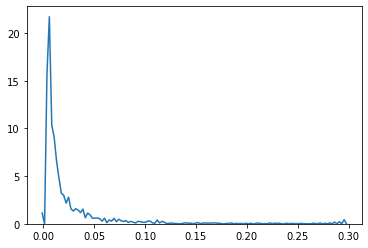

In [31]:
sns.kdeplot(pd.Series(preds.cpu().numpy().reshape(-1,)));

In [32]:
# Saving OOF predictions so stacking would be easier
pd.Series(oof.reshape(-1,)).to_csv(os.path.join(outdir,'oof.csv'), index=False)

In [33]:
if Kaggle:
    sub = pd.read_csv(PATH+'siim-isic-melanoma-classification/sample_submission.csv')
else:
    sub = pd.read_csv(PATH+ 'melanoma-external-malignant-256/sample_submission.csv')
sub['target'] = preds.cpu().numpy().reshape(-1,)
sub.to_csv(os.path.join(outdir,'submission.csv'), index=False)